## Define Libraries

In [ ]:
import numpy as np
import keras
import tensorflow as tf

from keras.datasets import cifar10
from keras.losses import sparse_categorical_crossentropy
from keras.optimizers import Adam
import matplotlib.pyplot as plt
from keras.models import Sequential, Model, load_model
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, Activation, Input, BatchNormalization, UpSampling2D
from keras.preprocessing.text import Tokenizer
from keras.wrappers.scikit_learn import KerasClassifier
from numpy.random import seed
from keras import regularizers, optimizers, layers, initializers
from keras.preprocessing.image import ImageDataGenerator
from keras.applications import VGG16


Using TensorFlow backend.


## Obtain the data
The data is pre-packaged in keras.

In [ ]:
# Load CIFAR-10 data
(input_train, target_train), (input_test, target_test) = cifar10.load_data()

## Prepare the data
First I will shape the data into the required format, and subsequently I will normalise (Take a Z score) for standardisation. I will then split into train-test-validation sets so that the subsequent analysis can be performed.

In [ ]:
no_classes=10
img_width, img_height, img_num_channels = 32, 32, 3


# Determine shape of the data
input_shape = (img_width, img_height, img_num_channels)

# Parse numbers as floats
input_train = input_train.astype('float32')
input_test = input_test.astype('float32')

####
X_train_mean = np.mean(input_train, axis=(0,1,2))
X_train_std = np.std(input_test, axis=(0,1,2))
input_train = (input_train - X_train_mean) / X_train_std
input_test = (input_test - X_train_mean) / X_train_std
###

import numpy as np
from sklearn.model_selection import train_test_split
input_train, input_val, target_train, target_val = train_test_split(input_train, target_train, test_size=0.2, random_state=42)

## Fit the model
I will start with a very big, basic model. I will overtrain it first and begin to optimise from there.

In [ ]:
model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(32, 32, 3)))
model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(MaxPooling2D((2, 2)))

model.add(Flatten())
model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
model.add(Dense(64, activation='relu', kernel_initializer='he_uniform'))
model.add(Dense(no_classes, activation='softmax'))


model.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

fit1 = model.fit(input_train, target_train,
            batch_size=64,
            epochs=100,
            verbose=1,
            validation_data=(input_val,target_val))

Train on 40000 samples, validate on 10000 samples
Epoch 1/100
40000/40000 [==============================] - 8s 206us/step - loss: 1.5655 - accuracy: 0.4365 - val_loss: 1.1651 - val_accuracy: 0.5832
Epoch 2/100
40000/40000 [==============================] - 6s 149us/step - loss: 1.0298 - accuracy: 0.6370 - val_loss: 0.9819 - val_accuracy: 0.6534
Epoch 3/100
40000/40000 [==============================] - 6s 149us/step - loss: 0.8118 - accuracy: 0.7145 - val_loss: 0.8219 - val_accuracy: 0.7112
Epoch 4/100
40000/40000 [==============================] - 6s 149us/step - loss: 0.6603 - accuracy: 0.7692 - val_loss: 0.8109 - val_accuracy: 0.7235
Epoch 5/100
40000/40000 [==============================] - 6s 149us/step - loss: 0.5571 - accuracy: 0.8062 - val_loss: 0.7839 - val_accuracy: 0.7418
Epoch 6/100
40000/40000 [==============================] - 6s 150us/step - loss: 0.4499 - accuracy: 0.8407 - val_loss: 0.7588 - val_accuracy: 0.7517
Epoch 7/100
40000/40000 [==============================]

## Visualisation


Here I will use my previously built function to visualise the epoch training

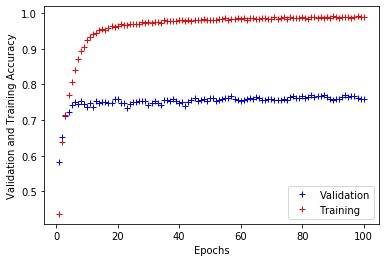

Maxima/minima of  accuracy/loss occurs at 0.7717000246047974 / 0.7587873078346252 respectively and this occurs at epochs 87 / 6 respectively.


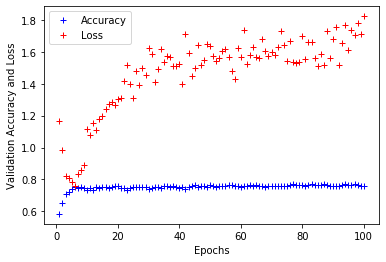

In [ ]:
def plotgraphs(fit, epoch):
    val_acc = fit.history['val_accuracy']
    acc = fit.history['accuracy']
    val_loss = fit.history['val_loss']
    
    maxacc = max(val_acc)
    minloss = min(val_loss)
    accepoch = val_acc.index(maxacc)+1
    lossepoch = val_loss.index(minloss)+1
    epochs = range(1, epoch+1)
    
    
    plt.plot(epochs, val_acc, 'b+', label='Validation')
    plt.plot(epochs, acc, 'r+', label='Training')
    plt.xlabel('Epochs')
    plt.ylabel('Validation and Training Accuracy')
    plt.legend()

    plt.show()


    plt.plot(epochs, val_acc, 'b+', label='Accuracy')
    plt.plot(epochs, val_loss, 'r+', label='Loss')
    plt.text(1.2, 1, print ('Maxima/minima of  accuracy/loss occurs at', maxacc,'/' , minloss,'respectively and this occurs at epochs', accepoch,'/',lossepoch, 'respectively.'))
    plt.xlabel('Epochs')
    plt.ylabel('Validation Accuracy and Loss')
    plt.legend()

    plt.show()
    
    
plotgraphs(fit1, 100)

Clearly overfitting after about 10 epochs. I will cut down the epochs first.

Train on 40000 samples, validate on 10000 samples
Epoch 1/10
40000/40000 [==============================] - 6s 161us/step - loss: 1.4867 - accuracy: 0.4641 - val_loss: 1.1067 - val_accuracy: 0.6104
Epoch 2/10
40000/40000 [==============================] - 6s 152us/step - loss: 0.9879 - accuracy: 0.6524 - val_loss: 0.9120 - val_accuracy: 0.6819
Epoch 3/10
40000/40000 [==============================] - 6s 152us/step - loss: 0.7699 - accuracy: 0.7281 - val_loss: 0.8015 - val_accuracy: 0.7237
Epoch 4/10
40000/40000 [==============================] - 6s 152us/step - loss: 0.6274 - accuracy: 0.7799 - val_loss: 0.7629 - val_accuracy: 0.7346
Epoch 5/10
40000/40000 [==============================] - 6s 154us/step - loss: 0.5091 - accuracy: 0.8213 - val_loss: 0.8897 - val_accuracy: 0.7147
Epoch 6/10
40000/40000 [==============================] - 6s 158us/step - loss: 0.4224 - accuracy: 0.8526 - val_loss: 0.7436 - val_accuracy: 0.7601
Epoch 7/10
40000/40000 [==============================] - 6s 1

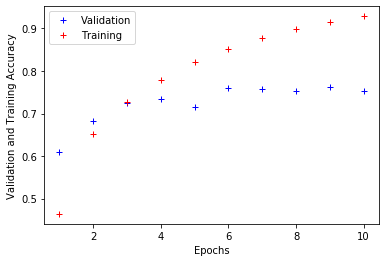

Maxima/minima of  accuracy/loss occurs at 0.7623999714851379 / 0.7435765226364136 respectively and this occurs at epochs 9 / 6 respectively.


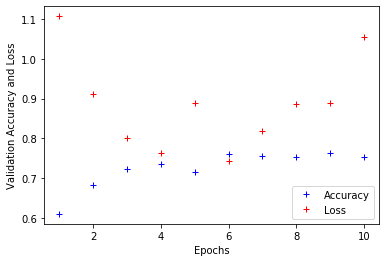

In [ ]:
model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(32, 32, 3)))
model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(MaxPooling2D((2, 2)))

model.add(Flatten())
model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
model.add(Dense(64, activation='relu', kernel_initializer='he_uniform'))
model.add(Dense(no_classes, activation='softmax'))


model.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

fit2 = model.fit(input_train, target_train,
            batch_size=64,
            epochs=10,
            verbose=1,
            validation_data=(input_val,target_val))

plotgraphs(fit2, 10)

In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 16, 16, 64)        18496     
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 16, 16, 64)        36928     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 8, 8, 64)          0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 8, 8, 128)        

Here it can be seen that the last conv layer transitions from 147584 paramters to 262272 paramaters in the first dense layer. In the hopes of maintaining simplicity, I will trial decreasing node count such that it funnels down systematically after the conv layers.

Train on 40000 samples, validate on 10000 samples
Epoch 1/10
40000/40000 [==============================] - 6s 160us/step - loss: 1.5876 - accuracy: 0.4254 - val_loss: 1.2428 - val_accuracy: 0.5610
Epoch 2/10
40000/40000 [==============================] - 6s 155us/step - loss: 1.0915 - accuracy: 0.6125 - val_loss: 0.9810 - val_accuracy: 0.6558
Epoch 3/10
40000/40000 [==============================] - 6s 156us/step - loss: 0.8423 - accuracy: 0.7017 - val_loss: 0.8877 - val_accuracy: 0.6926
Epoch 4/10
40000/40000 [==============================] - 6s 152us/step - loss: 0.6892 - accuracy: 0.7574 - val_loss: 0.9134 - val_accuracy: 0.6993
Epoch 5/10
40000/40000 [==============================] - 6s 151us/step - loss: 0.5559 - accuracy: 0.8023 - val_loss: 0.7855 - val_accuracy: 0.7418
Epoch 6/10
40000/40000 [==============================] - 6s 152us/step - loss: 0.4514 - accuracy: 0.8385 - val_loss: 0.8384 - val_accuracy: 0.7412
Epoch 7/10
40000/40000 [==============================] - 6s 1

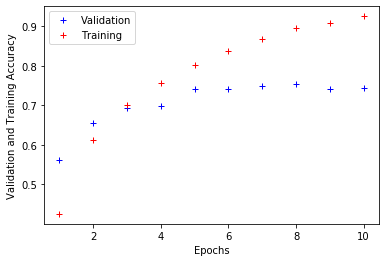

Maxima/minima of  accuracy/loss occurs at 0.7549999952316284 / 0.7854565743923188 respectively and this occurs at epochs 8 / 5 respectively.


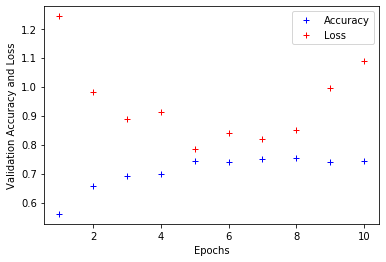

In [ ]:
model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(32, 32, 3)))
model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(MaxPooling2D((2, 2)))

model.add(Flatten())
model.add(Dense(64, activation='relu', kernel_initializer='he_uniform'))
model.add(Dense(32, activation='relu', kernel_initializer='he_uniform'))
model.add(Dense(no_classes, activation='softmax'))


model.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

fit2 = model.fit(input_train, target_train,
            batch_size=64,
            epochs=10,
            verbose=1,
            validation_data=(input_val,target_val))

plotgraphs(fit2, 10)

This does not seem to have helped. The model currently overtrains very quickly, signified by the divergence of training accuracy and validation accuracy. This in turn implies that the model will perform poorly on new data. To address the rate of overtraining, kernal weight regularisers will be trialled. I will try l2 first

Train on 40000 samples, validate on 10000 samples
Epoch 1/10
40000/40000 [==============================] - 7s 171us/step - loss: 1.6248 - accuracy: 0.4503 - val_loss: 1.2573 - val_accuracy: 0.5835
Epoch 2/10
40000/40000 [==============================] - 6s 160us/step - loss: 1.1082 - accuracy: 0.6460 - val_loss: 1.0041 - val_accuracy: 0.6838
Epoch 3/10
40000/40000 [==============================] - 7s 163us/step - loss: 0.9004 - accuracy: 0.7261 - val_loss: 0.8899 - val_accuracy: 0.7272
Epoch 4/10
40000/40000 [==============================] - 7s 163us/step - loss: 0.7719 - accuracy: 0.7752 - val_loss: 0.8776 - val_accuracy: 0.7442
Epoch 5/10
40000/40000 [==============================] - 7s 166us/step - loss: 0.6725 - accuracy: 0.8122 - val_loss: 0.8698 - val_accuracy: 0.7522
Epoch 6/10
40000/40000 [==============================] - 6s 161us/step - loss: 0.5963 - accuracy: 0.8415 - val_loss: 0.8653 - val_accuracy: 0.7647
Epoch 7/10
40000/40000 [==============================] - 6s 1

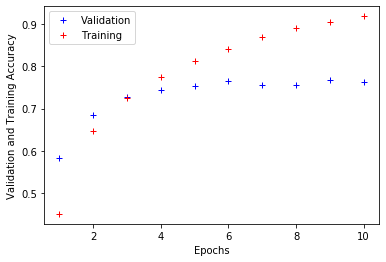

Maxima/minima of  accuracy/loss occurs at 0.7682999968528748 / 0.8652748454093933 respectively and this occurs at epochs 9 / 6 respectively.


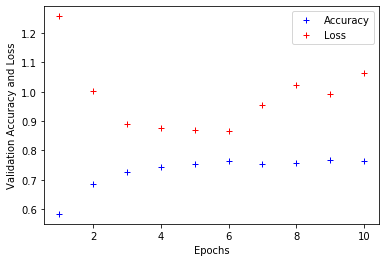

In [ ]:
model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', kernel_regularizer=regularizers.l1_l2(l1=0, l2=0.0001), kernel_initializer='he_uniform', padding='same', input_shape=(32, 32, 3)))
model.add(Conv2D(32, (3, 3), activation='relu', kernel_regularizer=regularizers.l1_l2(l1=0, l2=0.0001), kernel_initializer='he_uniform', padding='same'))
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(64, (3, 3), activation='relu', kernel_regularizer=regularizers.l1_l2(l1=0, l2=0.0001), kernel_initializer='he_uniform', padding='same'))
model.add(Conv2D(64, (3, 3), activation='relu', kernel_regularizer=regularizers.l1_l2(l1=0, l2=0.0001), kernel_initializer='he_uniform', padding='same'))
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(128, (3, 3), activation='relu', kernel_regularizer=regularizers.l1_l2(l1=0, l2=0.0001), kernel_initializer='he_uniform', padding='same'))
model.add(Conv2D(128, (3, 3), activation='relu', kernel_regularizer=regularizers.l1_l2(l1=0, l2=0.0001), kernel_initializer='he_uniform', padding='same'))
model.add(MaxPooling2D((2, 2)))

model.add(Flatten())
model.add(Dense(128, activation='relu', kernel_regularizer=regularizers.l1_l2(l1=0, l2=0.0001), kernel_initializer='he_uniform'))
model.add(Dense(64, activation='relu', kernel_regularizer=regularizers.l1_l2(l1=0, l2=0.0001), kernel_initializer='he_uniform'))
model.add(Dense(no_classes, activation='softmax'))

model.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

fit3 = model.fit(input_train, target_train,
            batch_size=64,
            epochs=10,
            verbose=1,
            validation_data=(input_val,target_val))

plotgraphs(fit3, 10)

This seems to have increased the models ability to generalise. It takes the model longer to overfit, and also begings overfitting at a higher validation accuracy than before. Next I will try l1 regularisation and see how that performs.

Train on 40000 samples, validate on 10000 samples
Epoch 1/10
40000/40000 [==============================] - 7s 167us/step - loss: 2.9981 - accuracy: 0.4335 - val_loss: 2.2971 - val_accuracy: 0.5560
Epoch 2/10
40000/40000 [==============================] - 6s 158us/step - loss: 1.9679 - accuracy: 0.6090 - val_loss: 1.7230 - val_accuracy: 0.6460
Epoch 3/10
40000/40000 [==============================] - 6s 157us/step - loss: 1.5517 - accuracy: 0.6841 - val_loss: 1.4712 - val_accuracy: 0.6904
Epoch 4/10
40000/40000 [==============================] - 6s 157us/step - loss: 1.3374 - accuracy: 0.7263 - val_loss: 1.3013 - val_accuracy: 0.7277
Epoch 5/10
40000/40000 [==============================] - 6s 157us/step - loss: 1.2058 - accuracy: 0.7550 - val_loss: 1.2622 - val_accuracy: 0.7246
Epoch 6/10
40000/40000 [==============================] - 6s 158us/step - loss: 1.1291 - accuracy: 0.7759 - val_loss: 1.2217 - val_accuracy: 0.7433
Epoch 7/10
40000/40000 [==============================] - 6s 1

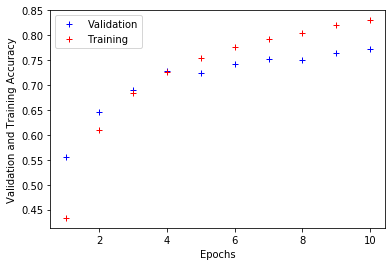

Maxima/minima of  accuracy/loss occurs at 0.7727000117301941 / 1.1438764338493348 respectively and this occurs at epochs 10 / 10 respectively.


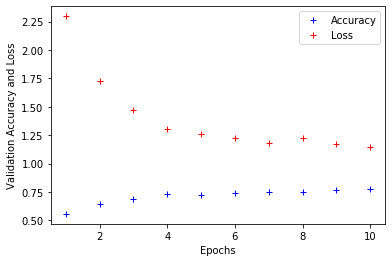

In [ ]:
model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', kernel_regularizer=regularizers.l1_l2(l1=0.0001, l2=0), kernel_initializer='he_uniform', padding='same', input_shape=(32, 32, 3)))
model.add(Conv2D(32, (3, 3), activation='relu', kernel_regularizer=regularizers.l1_l2(l1=0.0001, l2=0), kernel_initializer='he_uniform', padding='same'))
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(64, (3, 3), activation='relu', kernel_regularizer=regularizers.l1_l2(l1=0.0001, l2=0), kernel_initializer='he_uniform', padding='same'))
model.add(Conv2D(64, (3, 3), activation='relu', kernel_regularizer=regularizers.l1_l2(l1=0.0001, l2=0), kernel_initializer='he_uniform', padding='same'))
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(128, (3, 3), activation='relu', kernel_regularizer=regularizers.l1_l2(l1=0.0001, l2=0), kernel_initializer='he_uniform', padding='same'))
model.add(Conv2D(128, (3, 3), activation='relu', kernel_regularizer=regularizers.l1_l2(l1=0.0001, l2=0), kernel_initializer='he_uniform', padding='same'))
model.add(MaxPooling2D((2, 2)))

model.add(Flatten())
model.add(Dense(128, activation='relu', kernel_regularizer=regularizers.l1_l2(l1=0.0001, l2=0), kernel_initializer='he_uniform'))
model.add(Dense(64, activation='relu', kernel_regularizer=regularizers.l1_l2(l1=0.0001, l2=0), kernel_initializer='he_uniform'))
model.add(Dense(no_classes, activation='softmax'))

model.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

fit4 = model.fit(input_train, target_train,
            batch_size=64,
            epochs=10,
            verbose=1,
            validation_data=(input_val,target_val))

plotgraphs(fit4, 10)

Similarily, l1 seems to have had the same effect. I will add both to my subsequent models. Next in the aim of reducing overfitting, I will trial dropout. Dropout will cause the model to forget a set propotion of information, hopefully reducing the amount of noise learned.

Train on 40000 samples, validate on 10000 samples
Epoch 1/50
40000/40000 [==============================] - 7s 173us/step - loss: 2.2502 - accuracy: 0.1790 - val_loss: 1.9122 - val_accuracy: 0.2972
Epoch 2/50
40000/40000 [==============================] - 6s 161us/step - loss: 1.8086 - accuracy: 0.3372 - val_loss: 1.6535 - val_accuracy: 0.4216
Epoch 3/50
40000/40000 [==============================] - 6s 160us/step - loss: 1.6038 - accuracy: 0.4265 - val_loss: 1.4728 - val_accuracy: 0.4874
Epoch 4/50
40000/40000 [==============================] - 6s 159us/step - loss: 1.4831 - accuracy: 0.4875 - val_loss: 1.3704 - val_accuracy: 0.5372
Epoch 5/50
40000/40000 [==============================] - 6s 161us/step - loss: 1.3788 - accuracy: 0.5304 - val_loss: 1.2101 - val_accuracy: 0.5995
Epoch 6/50
40000/40000 [==============================] - 6s 160us/step - loss: 1.3081 - accuracy: 0.5653 - val_loss: 1.1792 - val_accuracy: 0.6065
Epoch 7/50
40000/40000 [==============================] - 6s 1

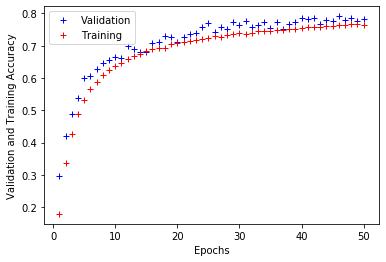

Maxima/minima of  accuracy/loss occurs at 0.7911999821662903 / 0.7558606985092163 respectively and this occurs at epochs 46 / 46 respectively.


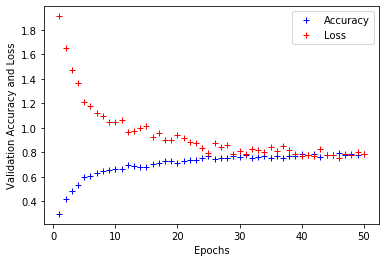

In [ ]:
model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', kernel_regularizer=regularizers.l1_l2(l1=0, l2=0.0001), kernel_initializer='he_uniform', padding='same', input_shape=(32, 32, 3)))
model.add(Conv2D(32, (3, 3), activation='relu', kernel_regularizer=regularizers.l1_l2(l1=0, l2=0.0001), kernel_initializer='he_uniform', padding='same'))

model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.5))

model.add(Conv2D(64, (3, 3), activation='relu', kernel_regularizer=regularizers.l1_l2(l1=0, l2=0.0001), kernel_initializer='he_uniform', padding='same'))
model.add(Conv2D(64, (3, 3), activation='relu', kernel_regularizer=regularizers.l1_l2(l1=0, l2=0.0001), kernel_initializer='he_uniform', padding='same'))

model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.5))

model.add(Conv2D(128, (3, 3), activation='relu', kernel_regularizer=regularizers.l1_l2(l1=0, l2=0.0001), kernel_initializer='he_uniform', padding='same'))
model.add(Conv2D(128, (3, 3), activation='relu', kernel_regularizer=regularizers.l1_l2(l1=0, l2=0.0001), kernel_initializer='he_uniform', padding='same'))

model.add(MaxPooling2D((2, 2)))
model.add(Flatten())
model.add(Dropout(0.5))

model.add(Dense(128, activation='relu', kernel_regularizer=regularizers.l1_l2(l1=0, l2=0), kernel_initializer='he_uniform'))
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu', kernel_regularizer=regularizers.l1_l2(l1=0, l2=0), kernel_initializer='he_uniform'))
model.add(Dense(no_classes, activation='softmax'))

model.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

fit4 = model.fit(input_train, target_train,
            batch_size=64,
            epochs=50,
            verbose=1,
            validation_data=(input_val,target_val))

plotgraphs(fit4, 50)

Wow this seems to have helped. I wonder if I can get the same effects with a lesser dropout value.

Train on 40000 samples, validate on 10000 samples
Epoch 1/50
40000/40000 [==============================] - 7s 178us/step - loss: 2.0937 - accuracy: 0.2650 - val_loss: 1.7018 - val_accuracy: 0.4121
Epoch 2/50
40000/40000 [==============================] - 7s 163us/step - loss: 1.6370 - accuracy: 0.4404 - val_loss: 1.4409 - val_accuracy: 0.5144
Epoch 3/50
40000/40000 [==============================] - 7s 163us/step - loss: 1.4561 - accuracy: 0.5133 - val_loss: 1.2689 - val_accuracy: 0.5861
Epoch 4/50
40000/40000 [==============================] - 7s 164us/step - loss: 1.3322 - accuracy: 0.5684 - val_loss: 1.1511 - val_accuracy: 0.6308
Epoch 5/50
40000/40000 [==============================] - 7s 164us/step - loss: 1.2419 - accuracy: 0.6050 - val_loss: 1.1270 - val_accuracy: 0.6462
Epoch 6/50
40000/40000 [==============================] - 7s 163us/step - loss: 1.1729 - accuracy: 0.6335 - val_loss: 1.0655 - val_accuracy: 0.6632
Epoch 7/50
40000/40000 [==============================] - 7s 1

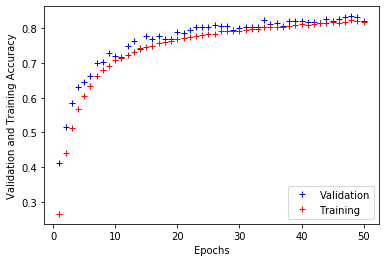

Maxima/minima of  accuracy/loss occurs at 0.8352000117301941 / 0.7389221241950988 respectively and this occurs at epochs 48 / 48 respectively.


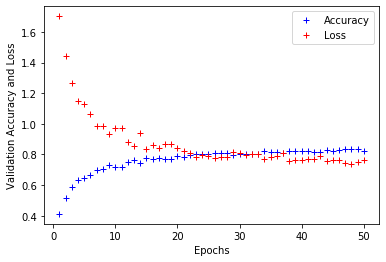

In [ ]:
model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', kernel_regularizer=regularizers.l1_l2(l1=0, l2=0.0001), kernel_initializer='he_uniform', padding='same', input_shape=(32, 32, 3)))
model.add(Conv2D(32, (3, 3), activation='relu', kernel_regularizer=regularizers.l1_l2(l1=0, l2=0.0001), kernel_initializer='he_uniform', padding='same'))

model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.4))

model.add(Conv2D(64, (3, 3), activation='relu', kernel_regularizer=regularizers.l1_l2(l1=0, l2=0.0001), kernel_initializer='he_uniform', padding='same'))
model.add(Conv2D(64, (3, 3), activation='relu', kernel_regularizer=regularizers.l1_l2(l1=0, l2=0.0001), kernel_initializer='he_uniform', padding='same'))

model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.4))

model.add(Conv2D(128, (3, 3), activation='relu', kernel_regularizer=regularizers.l1_l2(l1=0, l2=0.0001), kernel_initializer='he_uniform', padding='same',))
model.add(Conv2D(128, (3, 3), activation='relu', kernel_regularizer=regularizers.l1_l2(l1=0, l2=0.0001), kernel_initializer='he_uniform', padding='same'))

model.add(MaxPooling2D((2, 2)))
model.add(Flatten())
model.add(Dropout(0.4))

model.add(Dense(128, activation='relu', kernel_regularizer=regularizers.l1_l2(l1=0, l2=0.0001), kernel_initializer='he_uniform'))
model.add(Dropout(0.4))
model.add(Dense(64, activation='relu', kernel_regularizer=regularizers.l1_l2(l1=0, l2=0.0001), kernel_initializer='he_uniform'))
model.add(Dense(no_classes, activation='softmax'))

model.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

fit5 = model.fit(input_train, target_train,
            batch_size=64,
            epochs=50,
            verbose=1,
            validation_data=(input_val,target_val))

plotgraphs(fit5, 50)

This seems even better. Lets try an even lower dropout value. 

Train on 40000 samples, validate on 10000 samples
Epoch 1/50
40000/40000 [==============================] - 7s 176us/step - loss: 1.9603 - accuracy: 0.3189 - val_loss: 1.5627 - val_accuracy: 0.4860
Epoch 2/50
40000/40000 [==============================] - 7s 164us/step - loss: 1.4730 - accuracy: 0.5052 - val_loss: 1.2581 - val_accuracy: 0.5980
Epoch 3/50
40000/40000 [==============================] - 7s 164us/step - loss: 1.2709 - accuracy: 0.5901 - val_loss: 1.1809 - val_accuracy: 0.6280
Epoch 4/50
40000/40000 [==============================] - 7s 163us/step - loss: 1.1470 - accuracy: 0.6410 - val_loss: 0.9852 - val_accuracy: 0.6975
Epoch 5/50
40000/40000 [==============================] - 7s 164us/step - loss: 1.0659 - accuracy: 0.6759 - val_loss: 0.9591 - val_accuracy: 0.7052
Epoch 6/50
40000/40000 [==============================] - 7s 164us/step - loss: 1.0037 - accuracy: 0.6973 - val_loss: 0.9089 - val_accuracy: 0.7307
Epoch 7/50
40000/40000 [==============================] - 7s 1

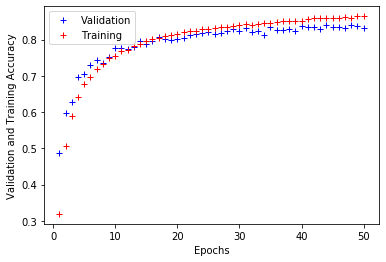

Maxima/minima of  accuracy/loss occurs at 0.8407999873161316 / 0.7571018122673034 respectively and this occurs at epochs 48 / 31 respectively.


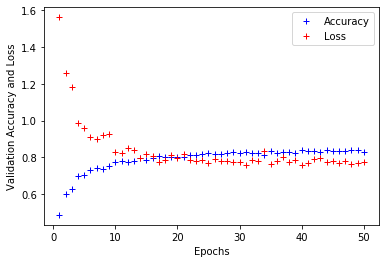

In [ ]:
model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', kernel_regularizer=regularizers.l1_l2(l1=0, l2=0.0001), kernel_initializer='he_uniform', padding='same', input_shape=(32, 32, 3)))
model.add(Conv2D(32, (3, 3), activation='relu', kernel_regularizer=regularizers.l1_l2(l1=0, l2=0.0001), kernel_initializer='he_uniform', padding='same'))

model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.3))

model.add(Conv2D(64, (3, 3), activation='relu', kernel_regularizer=regularizers.l1_l2(l1=0, l2=0.0001), kernel_initializer='he_uniform', padding='same'))
model.add(Conv2D(64, (3, 3), activation='relu', kernel_regularizer=regularizers.l1_l2(l1=0, l2=0.0001), kernel_initializer='he_uniform', padding='same'))

model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.3))

model.add(Conv2D(128, (3, 3), activation='relu', kernel_regularizer=regularizers.l1_l2(l1=0, l2=0.0001), kernel_initializer='he_uniform', padding='same',))
model.add(Conv2D(128, (3, 3), activation='relu', kernel_regularizer=regularizers.l1_l2(l1=0, l2=0.0001), kernel_initializer='he_uniform', padding='same'))

model.add(MaxPooling2D((2, 2)))
model.add(Flatten())
model.add(Dropout(0.3))

model.add(Dense(128, activation='relu', kernel_regularizer=regularizers.l1_l2(l1=0, l2=0.0001), kernel_initializer='he_uniform'))
model.add(Dropout(0.3))
model.add(Dense(64, activation='relu', kernel_regularizer=regularizers.l1_l2(l1=0, l2=0.0001), kernel_initializer='he_uniform'))
model.add(Dense(no_classes, activation='softmax'))

model.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

fit5 = model.fit(input_train, target_train,
            batch_size=64,
            epochs=50,
            verbose=1,
            validation_data=(input_val,target_val))

plotgraphs(fit5, 50)

This has not helped. The model seems to struggle to learn the patterns and stagnates in accuracy. Perhaps lets try an increasing dropout value. This may work as it will force the model to learn more specific information as it progresses. 

Train on 40000 samples, validate on 10000 samples
Epoch 1/50
40000/40000 [==============================] - 7s 177us/step - loss: 2.0750 - accuracy: 0.2667 - val_loss: 1.7144 - val_accuracy: 0.4040
Epoch 2/50
40000/40000 [==============================] - 7s 164us/step - loss: 1.5987 - accuracy: 0.4509 - val_loss: 1.3519 - val_accuracy: 0.5539
Epoch 3/50
40000/40000 [==============================] - 7s 164us/step - loss: 1.3977 - accuracy: 0.5420 - val_loss: 1.1644 - val_accuracy: 0.6345
Epoch 4/50
40000/40000 [==============================] - 7s 165us/step - loss: 1.2534 - accuracy: 0.6000 - val_loss: 1.0494 - val_accuracy: 0.6775
Epoch 5/50
40000/40000 [==============================] - 7s 164us/step - loss: 1.1622 - accuracy: 0.6423 - val_loss: 1.0304 - val_accuracy: 0.6889
Epoch 6/50
40000/40000 [==============================] - 7s 165us/step - loss: 1.0951 - accuracy: 0.6719 - val_loss: 0.9400 - val_accuracy: 0.7213
Epoch 7/50
40000/40000 [==============================] - 7s 1

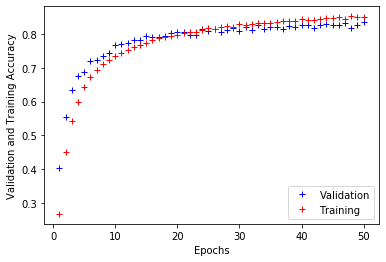

Maxima/minima of  accuracy/loss occurs at 0.8373000025749207 / 0.7697719048500061 respectively and this occurs at epochs 50 / 33 respectively.


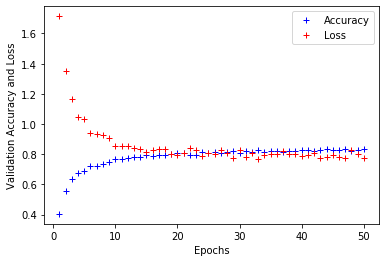

In [ ]:
model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', kernel_regularizer=regularizers.l1_l2(l1=0, l2=0.0001), kernel_initializer='he_uniform', padding='same', input_shape=(32, 32, 3)))
model.add(Conv2D(32, (3, 3), activation='relu', kernel_regularizer=regularizers.l1_l2(l1=0, l2=0.0001), kernel_initializer='he_uniform', padding='same'))

model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.2))

model.add(Conv2D(64, (3, 3), activation='relu', kernel_regularizer=regularizers.l1_l2(l1=0, l2=0.0001), kernel_initializer='he_uniform', padding='same'))
model.add(Conv2D(64, (3, 3), activation='relu', kernel_regularizer=regularizers.l1_l2(l1=0, l2=0.0001), kernel_initializer='he_uniform', padding='same'))

model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.3))

model.add(Conv2D(128, (3, 3), activation='relu', kernel_regularizer=regularizers.l1_l2(l1=0, l2=0.0001), kernel_initializer='he_uniform', padding='same',))
model.add(Conv2D(128, (3, 3), activation='relu', kernel_regularizer=regularizers.l1_l2(l1=0, l2=0.0001), kernel_initializer='he_uniform', padding='same'))

model.add(MaxPooling2D((2, 2)))
model.add(Flatten())
model.add(Dropout(0.4))

model.add(Dense(128, activation='relu', kernel_regularizer=regularizers.l1_l2(l1=0, l2=0.0001), kernel_initializer='he_uniform'))
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu', kernel_regularizer=regularizers.l1_l2(l1=0, l2=0.0001), kernel_initializer='he_uniform'))
model.add(Dense(no_classes, activation='softmax'))

model.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

fit5 = model.fit(input_train, target_train,
            batch_size=64,
            epochs=50,
            verbose=1,
            validation_data=(input_val,target_val))

plotgraphs(fit5, 50)

Okay this has not worked. The model has started overtraining much faster with only a very slight increase in accuracy. I have read up on batch normalisation and it seems that this will further the models ability to generalise (see report for more information). Lets try it 

Train on 40000 samples, validate on 10000 samples
Epoch 1/50
40000/40000 [==============================] - 10s 255us/step - loss: 2.0821 - accuracy: 0.2743 - val_loss: 2.0322 - val_accuracy: 0.3325
Epoch 2/50
40000/40000 [==============================] - 9s 233us/step - loss: 1.6845 - accuracy: 0.4264 - val_loss: 1.5834 - val_accuracy: 0.4611
Epoch 3/50
40000/40000 [==============================] - 9s 233us/step - loss: 1.4930 - accuracy: 0.5061 - val_loss: 1.3315 - val_accuracy: 0.5761
Epoch 4/50
40000/40000 [==============================] - 9s 233us/step - loss: 1.3525 - accuracy: 0.5671 - val_loss: 1.2296 - val_accuracy: 0.6099
Epoch 5/50
40000/40000 [==============================] - 9s 234us/step - loss: 1.2365 - accuracy: 0.6212 - val_loss: 1.0718 - val_accuracy: 0.6803
Epoch 6/50
40000/40000 [==============================] - 9s 233us/step - loss: 1.1434 - accuracy: 0.6567 - val_loss: 1.0354 - val_accuracy: 0.6949
Epoch 7/50
40000/40000 [==============================] - 9s 

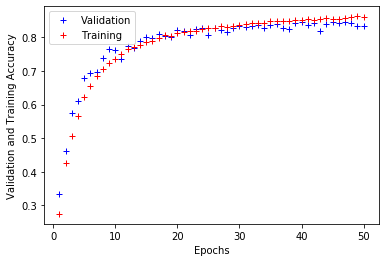

Maxima/minima of  accuracy/loss occurs at 0.8463000059127808 / 0.751438678264618 respectively and this occurs at epochs 47 / 47 respectively.


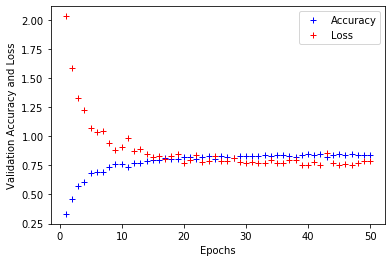

In [ ]:
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', kernel_regularizer=regularizers.l1_l2(l1=0, l2=0.0001), kernel_initializer='he_uniform', padding='same', input_shape=(32, 32, 3)))
model.add(Conv2D(32, (3, 3), activation='relu', kernel_regularizer=regularizers.l1_l2(l1=0, l2=0.0001), kernel_initializer='he_uniform', padding='same'))

model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.4))

model.add(Conv2D(64, (3, 3), activation='relu', kernel_regularizer=regularizers.l1_l2(l1=0, l2=0.0001), kernel_initializer='he_uniform', padding='same'))
model.add(Conv2D(64, (3, 3), activation='relu', kernel_regularizer=regularizers.l1_l2(l1=0, l2=0.0001), kernel_initializer='he_uniform', padding='same'))

model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.4))

model.add(Conv2D(128, (3, 3), activation='relu', kernel_regularizer=regularizers.l1_l2(l1=0, l2=0.0001), kernel_initializer='he_uniform', padding='same',))
model.add(Conv2D(128, (3, 3), activation='relu', kernel_regularizer=regularizers.l1_l2(l1=0, l2=0.0001), kernel_initializer='he_uniform', padding='same'))

model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Flatten())
model.add(Dropout(0.4))

model.add(Dense(128, activation='relu', kernel_regularizer=regularizers.l1_l2(l1=0, l2=0.0001), kernel_initializer='he_uniform'))
model.add(Dropout(0.4))
model.add(Dense(64, activation='relu', kernel_regularizer=regularizers.l1_l2(l1=0, l2=0.0001), kernel_initializer='he_uniform'))
model.add(Dense(no_classes, activation='softmax'))

model.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

fit5 = model.fit(input_train, target_train,
            batch_size=64,
            epochs=50,
            verbose=1,
            validation_data=(input_val,target_val))

plotgraphs(fit5, 50)

This has helped even further. Next lets investigate the 'elu' activation function (see report for reasoning).

Train on 40000 samples, validate on 10000 samples
Epoch 1/50
40000/40000 [==============================] - 11s 264us/step - loss: 1.9735 - accuracy: 0.3424 - val_loss: 1.5977 - val_accuracy: 0.4605
Epoch 2/50
40000/40000 [==============================] - 10s 243us/step - loss: 1.5300 - accuracy: 0.4917 - val_loss: 1.2532 - val_accuracy: 0.6000
Epoch 3/50
40000/40000 [==============================] - 9s 236us/step - loss: 1.2963 - accuracy: 0.5871 - val_loss: 1.1042 - val_accuracy: 0.6585
Epoch 4/50
40000/40000 [==============================] - 10s 239us/step - loss: 1.1525 - accuracy: 0.6446 - val_loss: 0.9496 - val_accuracy: 0.7234
Epoch 5/50
40000/40000 [==============================] - 10s 238us/step - loss: 1.0560 - accuracy: 0.6894 - val_loss: 0.8863 - val_accuracy: 0.7421
Epoch 6/50
40000/40000 [==============================] - 9s 234us/step - loss: 1.0029 - accuracy: 0.7092 - val_loss: 0.9289 - val_accuracy: 0.7378
Epoch 7/50
40000/40000 [==============================] - 

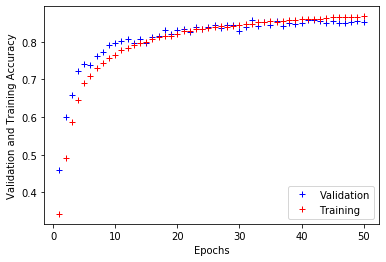

Maxima/minima of  accuracy/loss occurs at 0.8589000105857849 / 0.7140593257904053 respectively and this occurs at epochs 41 / 32 respectively.


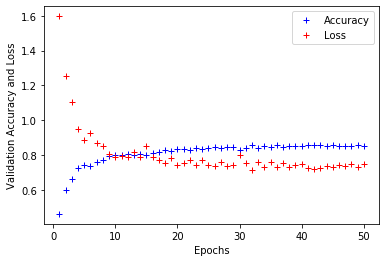

In [ ]:
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='elu', kernel_regularizer=regularizers.l1_l2(l1=0, l2=0.0001), kernel_initializer='he_uniform', padding='same', input_shape=(32, 32, 3)))
model.add(Conv2D(32, (3, 3), activation='elu', kernel_regularizer=regularizers.l1_l2(l1=0, l2=0.0001), kernel_initializer='he_uniform', padding='same'))

model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.4))

model.add(Conv2D(64, (3, 3), activation='elu', kernel_regularizer=regularizers.l1_l2(l1=0, l2=0.0001), kernel_initializer='he_uniform', padding='same'))
model.add(Conv2D(64, (3, 3), activation='elu', kernel_regularizer=regularizers.l1_l2(l1=0, l2=0.0001), kernel_initializer='he_uniform', padding='same'))

model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.4))

model.add(Conv2D(128, (3, 3), activation='elu', kernel_regularizer=regularizers.l1_l2(l1=0, l2=0.0001), kernel_initializer='he_uniform', padding='same',))
model.add(Conv2D(128, (3, 3), activation='elu', kernel_regularizer=regularizers.l1_l2(l1=0, l2=0.0001), kernel_initializer='he_uniform', padding='same'))


model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Flatten())
model.add(Dropout(0.4))

model.add(Dense(128, activation='elu', kernel_regularizer=regularizers.l1_l2(l1=0, l2=0.0001), kernel_initializer='he_uniform'))
model.add(Dropout(0.4))
model.add(Dense(64, activation='elu', kernel_regularizer=regularizers.l1_l2(l1=0, l2=0.0001), kernel_initializer='he_uniform'))
model.add(Dense(no_classes, activation='softmax'))

model.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

fit5 = model.fit(input_train, target_train,
            batch_size=64,
            epochs=50,
            verbose=1,
            validation_data=(input_val,target_val))

plotgraphs(fit5, 50)

Finally, I have established a general shape and pattern for each layer. Next I will investigate how many layers are required using this outlined structure.

Train on 40000 samples, validate on 10000 samples
Epoch 1/125
40000/40000 [==============================] - 9s 225us/step - loss: 1.9584 - accuracy: 0.3422 - val_loss: 1.6017 - val_accuracy: 0.4778
Epoch 2/125
40000/40000 [==============================] - 8s 210us/step - loss: 1.4753 - accuracy: 0.4967 - val_loss: 1.1935 - val_accuracy: 0.6024
Epoch 3/125
40000/40000 [==============================] - 8s 208us/step - loss: 1.2619 - accuracy: 0.5892 - val_loss: 1.0562 - val_accuracy: 0.6631
Epoch 4/125
40000/40000 [==============================] - 8s 204us/step - loss: 1.1322 - accuracy: 0.6409 - val_loss: 0.9914 - val_accuracy: 0.6918
Epoch 5/125
40000/40000 [==============================] - 8s 202us/step - loss: 1.0519 - accuracy: 0.6719 - val_loss: 0.9076 - val_accuracy: 0.7230
Epoch 6/125
40000/40000 [==============================] - 8s 199us/step - loss: 0.9957 - accuracy: 0.6984 - val_loss: 0.8897 - val_accuracy: 0.7374
Epoch 7/125
40000/40000 [==============================]

40000/40000 [==============================] - 8s 198us/step - loss: 0.6451 - accuracy: 0.8788 - val_loss: 0.8214 - val_accuracy: 0.8369
Epoch 110/125
40000/40000 [==============================] - 8s 199us/step - loss: 0.6466 - accuracy: 0.8777 - val_loss: 0.7807 - val_accuracy: 0.8441
Epoch 111/125
40000/40000 [==============================] - 8s 198us/step - loss: 0.6442 - accuracy: 0.8794 - val_loss: 0.8116 - val_accuracy: 0.8333
Epoch 112/125
40000/40000 [==============================] - 8s 199us/step - loss: 0.6518 - accuracy: 0.8755 - val_loss: 0.7867 - val_accuracy: 0.8409
Epoch 113/125
40000/40000 [==============================] - 8s 198us/step - loss: 0.6401 - accuracy: 0.8787 - val_loss: 0.8282 - val_accuracy: 0.8336
Epoch 114/125
40000/40000 [==============================] - 8s 199us/step - loss: 0.6433 - accuracy: 0.8779 - val_loss: 0.7869 - val_accuracy: 0.8386
Epoch 115/125
40000/40000 [==============================] - 8s 198us/step - loss: 0.6344 - accuracy: 0.8810

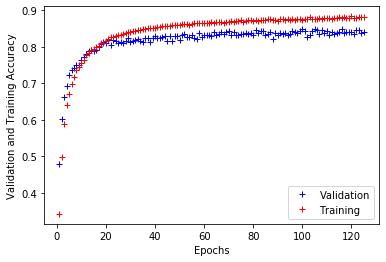

Maxima/minima of  accuracy/loss occurs at 0.8496999740600586 / 0.7702331939697266 respectively and this occurs at epochs 100 / 100 respectively.


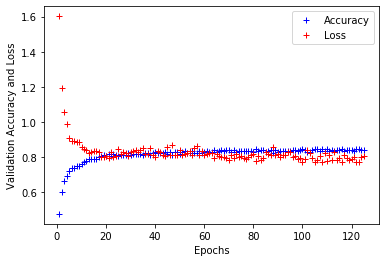

In [ ]:
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='elu', kernel_regularizer=regularizers.l1_l2(l1=0, l2=0.0001), kernel_initializer='he_uniform', padding='same', input_shape=(32, 32, 3)))
model.add(Conv2D(32, (3, 3), activation='elu', kernel_regularizer=regularizers.l1_l2(l1=0, l2=0.0001), kernel_initializer='he_uniform', padding='same'))

model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.4))

model.add(Conv2D(64, (3, 3), activation='elu', kernel_regularizer=regularizers.l1_l2(l1=0, l2=0.0001), kernel_initializer='he_uniform', padding='same'))
model.add(Conv2D(64, (3, 3), activation='elu', kernel_regularizer=regularizers.l1_l2(l1=0, l2=0.0001), kernel_initializer='he_uniform', padding='same'))

model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Flatten())
model.add(Dropout(0.4))

model.add(Dense(128, activation='elu', kernel_regularizer=regularizers.l1_l2(l1=0, l2=0.0001), kernel_initializer='he_uniform'))
model.add(Dropout(0.4))
model.add(Dense(64, activation='elu', kernel_regularizer=regularizers.l1_l2(l1=0, l2=0.0001), kernel_initializer='he_uniform'))
model.add(Dense(no_classes, activation='softmax'))

model.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

fit6 = model.fit(input_train, target_train,
            batch_size=64,
            epochs=125,
            verbose=1,
            validation_data=(input_val,target_val))

plotgraphs(fit6, 125)

Here it can be seen that the model is underfitting. It is struggling to learn the general strucutre of the feature space and is stagnating a little bit. If this model were to be kept, training time would be massive due to the number of epochs required, and also it is not certain whetehr this would actually help external accuracy. Next lets try 5 layers.

Train on 40000 samples, validate on 10000 samples
Epoch 1/50
40000/40000 [==============================] - 13s 322us/step - loss: 2.1124 - accuracy: 0.3220 - val_loss: 1.7267 - val_accuracy: 0.4424
Epoch 2/50
40000/40000 [==============================] - 11s 286us/step - loss: 1.6283 - accuracy: 0.4940 - val_loss: 1.3739 - val_accuracy: 0.5901
Epoch 3/50
40000/40000 [==============================] - 11s 286us/step - loss: 1.4087 - accuracy: 0.5879 - val_loss: 1.3522 - val_accuracy: 0.6196
Epoch 4/50
40000/40000 [==============================] - 11s 286us/step - loss: 1.2673 - accuracy: 0.6461 - val_loss: 1.0911 - val_accuracy: 0.7043
Epoch 5/50
40000/40000 [==============================] - 11s 286us/step - loss: 1.1649 - accuracy: 0.6859 - val_loss: 1.0070 - val_accuracy: 0.7373
Epoch 6/50
40000/40000 [==============================] - 12s 288us/step - loss: 1.0938 - accuracy: 0.7155 - val_loss: 0.9520 - val_accuracy: 0.7590
Epoch 7/50
40000/40000 [==============================] 

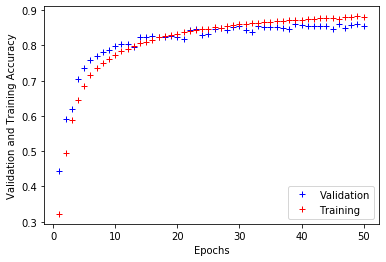

Maxima/minima of  accuracy/loss occurs at 0.8607000112533569 / 0.8102875939369202 respectively and this occurs at epochs 39 / 39 respectively.


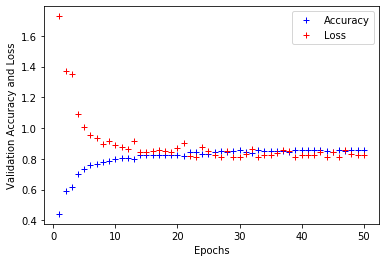

In [ ]:
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='elu', kernel_regularizer=regularizers.l1_l2(l1=0, l2=0.0001), kernel_initializer='he_uniform', padding='same', input_shape=(32, 32, 3)))
model.add(Conv2D(32, (3, 3), activation='elu', kernel_regularizer=regularizers.l1_l2(l1=0, l2=0.0001), kernel_initializer='he_uniform', padding='same'))

model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.4))

model.add(Conv2D(64, (3, 3), activation='elu', kernel_regularizer=regularizers.l1_l2(l1=0, l2=0.0001), kernel_initializer='he_uniform', padding='same'))
model.add(Conv2D(64, (3, 3), activation='elu', kernel_regularizer=regularizers.l1_l2(l1=0, l2=0.0001), kernel_initializer='he_uniform', padding='same'))

model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.4))

model.add(Conv2D(128, (3, 3), activation='elu', kernel_regularizer=regularizers.l1_l2(l1=0, l2=0.0001), kernel_initializer='he_uniform', padding='same'))
model.add(Conv2D(128, (3, 3), activation='elu', kernel_regularizer=regularizers.l1_l2(l1=0, l2=0.0001), kernel_initializer='he_uniform', padding='same'))

model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.4))

model.add(Conv2D(256, (3, 3), activation='elu', kernel_regularizer=regularizers.l1_l2(l1=0, l2=0.0001), kernel_initializer='he_uniform', padding='same'))
model.add(Conv2D(256, (3, 3), activation='elu', kernel_regularizer=regularizers.l1_l2(l1=0, l2=0.0001), kernel_initializer='he_uniform', padding='same'))

model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Flatten())
model.add(Dropout(0.4))

model.add(Dense(128, activation='elu', kernel_regularizer=regularizers.l1_l2(l1=0, l2=0.0001), kernel_initializer='he_uniform'))
model.add(Dropout(0.4))
model.add(Dense(64, activation='elu', kernel_regularizer=regularizers.l1_l2(l1=0, l2=0.0001), kernel_initializer='he_uniform'))
model.add(Dense(no_classes, activation='softmax'))

model.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

fit6 = model.fit(input_train, target_train,
            batch_size=64,
            epochs=50,
            verbose=1,
            validation_data=(input_val,target_val))

plotgraphs(fit6, 50)

This seems like overkill. The model does not seem to have experienced any discenrable benefit at the point of overfitting and has also increased in size. Therefore in the name of maintaining the simplest model for any given performance, I will not use this structure. 

Lets investigate a reduction in overall parameter count.

Train on 40000 samples, validate on 10000 samples
Epoch 1/150
40000/40000 [==============================] - 9s 215us/step - loss: 1.9938 - accuracy: 0.2984 - val_loss: 1.6420 - val_accuracy: 0.4367
Epoch 2/150
40000/40000 [==============================] - 7s 180us/step - loss: 1.6020 - accuracy: 0.4340 - val_loss: 1.4263 - val_accuracy: 0.5105
Epoch 3/150
40000/40000 [==============================] - 7s 179us/step - loss: 1.4403 - accuracy: 0.4989 - val_loss: 1.1983 - val_accuracy: 0.5936
Epoch 4/150
40000/40000 [==============================] - 7s 179us/step - loss: 1.3151 - accuracy: 0.5536 - val_loss: 1.1269 - val_accuracy: 0.6118
Epoch 5/150
40000/40000 [==============================] - 7s 179us/step - loss: 1.2237 - accuracy: 0.5938 - val_loss: 1.1416 - val_accuracy: 0.6193
Epoch 6/150
40000/40000 [==============================] - 7s 179us/step - loss: 1.1556 - accuracy: 0.6195 - val_loss: 0.9628 - val_accuracy: 0.6787
Epoch 7/150
40000/40000 [==============================]

40000/40000 [==============================] - 7s 180us/step - loss: 0.6939 - accuracy: 0.8076 - val_loss: 0.6565 - val_accuracy: 0.8269
Epoch 110/150
40000/40000 [==============================] - 7s 179us/step - loss: 0.6894 - accuracy: 0.8082 - val_loss: 0.6493 - val_accuracy: 0.8282
Epoch 111/150
40000/40000 [==============================] - 7s 179us/step - loss: 0.6862 - accuracy: 0.8126 - val_loss: 0.6498 - val_accuracy: 0.8232
Epoch 112/150
40000/40000 [==============================] - 7s 179us/step - loss: 0.6850 - accuracy: 0.8129 - val_loss: 0.6425 - val_accuracy: 0.8293
Epoch 113/150
40000/40000 [==============================] - 7s 179us/step - loss: 0.6862 - accuracy: 0.8102 - val_loss: 0.6269 - val_accuracy: 0.8337
Epoch 114/150
40000/40000 [==============================] - 7s 180us/step - loss: 0.6929 - accuracy: 0.8083 - val_loss: 0.6431 - val_accuracy: 0.8277
Epoch 115/150
40000/40000 [==============================] - 7s 179us/step - loss: 0.6847 - accuracy: 0.8123

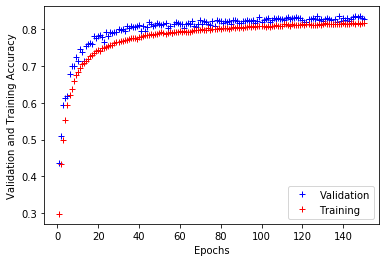

Maxima/minima of  accuracy/loss occurs at 0.8343999981880188 / 0.6268950248241425 respectively and this occurs at epochs 148 / 113 respectively.


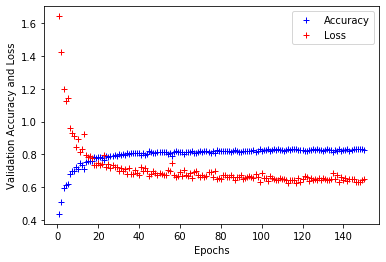

In [ ]:
model = Sequential()
model.add(Conv2D(16, (3, 3), activation='elu', kernel_regularizer=regularizers.l1_l2(l1=0, l2=0.0001), kernel_initializer='he_uniform', padding='same', input_shape=(32, 32, 3)))
model.add(Conv2D(16, (3, 3), activation='elu', kernel_regularizer=regularizers.l1_l2(l1=0, l2=0.0001), kernel_initializer='he_uniform', padding='same'))

model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.4))

model.add(Conv2D(32, (3, 3), activation='elu', kernel_regularizer=regularizers.l1_l2(l1=0, l2=0.0001), kernel_initializer='he_uniform', padding='same'))
model.add(Conv2D(32, (3, 3), activation='elu', kernel_regularizer=regularizers.l1_l2(l1=0, l2=0.0001), kernel_initializer='he_uniform', padding='same'))

model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.4))

model.add(Conv2D(64, (3, 3), activation='elu', kernel_regularizer=regularizers.l1_l2(l1=0, l2=0.0001), kernel_initializer='he_uniform', padding='same',))
model.add(Conv2D(64, (3, 3), activation='elu', kernel_regularizer=regularizers.l1_l2(l1=0, l2=0.0001), kernel_initializer='he_uniform', padding='same'))


model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Flatten())
model.add(Dropout(0.4))

model.add(Dense(64, activation='elu', kernel_regularizer=regularizers.l1_l2(l1=0, l2=0.0001), kernel_initializer='he_uniform'))
model.add(Dropout(0.4))
model.add(Dense(32, activation='elu', kernel_regularizer=regularizers.l1_l2(l1=0, l2=0.0001), kernel_initializer='he_uniform'))
model.add(Dense(no_classes, activation='softmax'))

model.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

fit5 = model.fit(input_train, target_train,
            batch_size=64,
            epochs=150,
            verbose=1,
            validation_data=(input_val,target_val))

plotgraphs(fit5, 150)

Finally, lets do some data augmentation. This is where training data can be slightly increased in size through small translations and shifts of the original data. An increase in the amount of data available for training is an effective way of increasing a models ability to generalise and learn patterns.

Epoch 1/200
625/625 [==============================] - 14s 23ms/step - loss: 2.0706 - accuracy: 0.3060 - val_loss: 1.6658 - val_accuracy: 0.4267
Epoch 2/200
625/625 [==============================] - 15s 24ms/step - loss: 1.6551 - accuracy: 0.4440 - val_loss: 1.5626 - val_accuracy: 0.4753
Epoch 3/200
625/625 [==============================] - 13s 21ms/step - loss: 1.4761 - accuracy: 0.5181 - val_loss: 1.3090 - val_accuracy: 0.5824
Epoch 4/200
625/625 [==============================] - 13s 22ms/step - loss: 1.3380 - accuracy: 0.5733 - val_loss: 1.0562 - val_accuracy: 0.6789
Epoch 5/200
625/625 [==============================] - 15s 24ms/step - loss: 1.2458 - accuracy: 0.6136 - val_loss: 1.1145 - val_accuracy: 0.6553
Epoch 6/200
625/625 [==============================] - 14s 22ms/step - loss: 1.1746 - accuracy: 0.6417 - val_loss: 0.9944 - val_accuracy: 0.7093
Epoch 7/200
625/625 [==============================] - 13s 21ms/step - loss: 1.1230 - accuracy: 0.6691 - val_loss: 0.9772 - val_ac

625/625 [==============================] - 14s 22ms/step - loss: 0.4490 - accuracy: 0.8899 - val_loss: 0.4631 - val_accuracy: 0.8933
Epoch 113/200
625/625 [==============================] - 15s 24ms/step - loss: 0.4395 - accuracy: 0.8942 - val_loss: 0.4644 - val_accuracy: 0.8935
Epoch 114/200
625/625 [==============================] - 13s 21ms/step - loss: 0.4397 - accuracy: 0.8939 - val_loss: 0.4619 - val_accuracy: 0.8935
Epoch 115/200
625/625 [==============================] - 13s 21ms/step - loss: 0.4436 - accuracy: 0.8923 - val_loss: 0.4640 - val_accuracy: 0.8934
Epoch 116/200
625/625 [==============================] - 15s 24ms/step - loss: 0.4427 - accuracy: 0.8941 - val_loss: 0.4625 - val_accuracy: 0.8937
Epoch 117/200
625/625 [==============================] - 13s 21ms/step - loss: 0.4384 - accuracy: 0.8962 - val_loss: 0.4625 - val_accuracy: 0.8936
Epoch 118/200
625/625 [==============================] - 13s 21ms/step - loss: 0.4415 - accuracy: 0.8942 - val_loss: 0.4637 - val_ac

Epoch 168/200
625/625 [==============================] - 15s 23ms/step - loss: 0.4374 - accuracy: 0.8958 - val_loss: 0.4619 - val_accuracy: 0.8946
Epoch 169/200
625/625 [==============================] - 14s 23ms/step - loss: 0.4381 - accuracy: 0.8933 - val_loss: 0.4618 - val_accuracy: 0.8942
Epoch 170/200
625/625 [==============================] - 16s 25ms/step - loss: 0.4376 - accuracy: 0.8953 - val_loss: 0.4615 - val_accuracy: 0.8948
Epoch 171/200
625/625 [==============================] - 13s 21ms/step - loss: 0.4372 - accuracy: 0.8972 - val_loss: 0.4619 - val_accuracy: 0.8942
Epoch 172/200
625/625 [==============================] - 14s 23ms/step - loss: 0.4369 - accuracy: 0.8941 - val_loss: 0.4627 - val_accuracy: 0.8940
Epoch 173/200
625/625 [==============================] - 16s 26ms/step - loss: 0.4393 - accuracy: 0.8948 - val_loss: 0.4629 - val_accuracy: 0.8949
Epoch 174/200
625/625 [==============================] - 14s 23ms/step - loss: 0.4401 - accuracy: 0.8950 - val_loss: 0

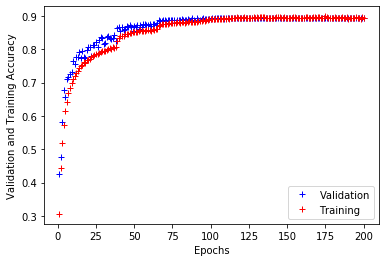

Maxima/minima of  accuracy/loss occurs at 0.8952000141143799 / 0.4603732254981995 respectively and this occurs at epochs 174 / 177 respectively.


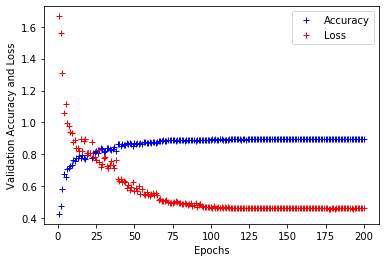

In [ ]:
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='elu', kernel_regularizer=regularizers.l1_l2(l1=0, l2=0.0001), kernel_initializer='he_uniform', padding='same', input_shape=(32, 32, 3)))
model.add(Conv2D(32, (3, 3), activation='elu', kernel_regularizer=regularizers.l1_l2(l1=0, l2=0.0001), kernel_initializer='he_uniform', padding='same'))

model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.4))

model.add(Conv2D(64, (3, 3), activation='elu', kernel_regularizer=regularizers.l1_l2(l1=0, l2=0.0001), kernel_initializer='he_uniform', padding='same'))
model.add(Conv2D(64, (3, 3), activation='elu', kernel_regularizer=regularizers.l1_l2(l1=0, l2=0.0001), kernel_initializer='he_uniform', padding='same'))

model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.4))

model.add(Conv2D(128, (3, 3), activation='elu', kernel_regularizer=regularizers.l1_l2(l1=0, l2=0.0001), kernel_initializer='he_uniform', padding='same',))
model.add(Conv2D(128, (3, 3), activation='elu', kernel_regularizer=regularizers.l1_l2(l1=0, l2=0.0001), kernel_initializer='he_uniform', padding='same'))

model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Flatten())
model.add(Dropout(0.4))

model.add(Dense(128, activation='elu', kernel_regularizer=regularizers.l1_l2(l1=0, l2=0.0001), kernel_initializer='he_uniform'))
model.add(Dropout(0.4))
model.add(Dense(64, activation='elu', kernel_regularizer=regularizers.l1_l2(l1=0, l2=0.0001), kernel_initializer='he_uniform'))
model.add(Dense(no_classes, activation='softmax'))

model.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])


datagen = ImageDataGenerator(width_shift_range=0.1, height_shift_range=0.1, horizontal_flip=True)
it_train = datagen.flow(input_train, target_train, batch_size=64)
steps = int(input_train.shape[0] / 64)
augmodel = model.fit_generator(it_train, steps_per_epoch=steps, epochs=200, validation_data=(input_val,target_val), verbose=1)
plotgraphs(augmodel, 200)

Wow this has helped greatly, with a massive increase in peak validation accuracy.

In [ ]:
model.save('dataug.h5')
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_13 (Conv2D)           (None, 32, 32, 32)        896       
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 32, 32, 32)        9248      
_________________________________________________________________
batch_normalization_7 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
dropout_9 (Dropout)          (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 16, 16, 64)        18496     
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 16, 16, 64)       

This is good, lets try using a pretrained CONV Base AND augmentation. The keras documentation indicates that the VGG19 model requires an image size of at least 48x48 due to being trained on imagenet. I will use an upsampling layer before the VGG19 layer to achieve this.

In [ ]:
base_model = VGG19(
    weights='imagenet',
    include_top=False)
base_model.summary()

Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, None, None, 3)     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0     

In [ ]:
base_model.trainable=False

Epoch 1/100
625/625 [==============================] - 24s 38ms/step - loss: 1.2298 - accuracy: 0.5767 - val_loss: 0.8224 - val_accuracy: 0.7210accura
Epoch 2/100
625/625 [==============================] - 23s 37ms/step - loss: 0.9995 - accuracy: 0.6577 - val_loss: 0.7804 - val_accuracy: 0.7342
Epoch 3/100
625/625 [==============================] - 23s 36ms/step - loss: 0.9536 - accuracy: 0.6729 - val_loss: 0.7449 - val_accuracy: 0.7472
Epoch 4/100
625/625 [==============================] - 23s 37ms/step - loss: 0.9122 - accuracy: 0.6926 - val_loss: 0.7395 - val_accuracy: 0.7490
Epoch 5/100
625/625 [==============================] - 23s 37ms/step - loss: 0.8945 - accuracy: 0.6977 - val_loss: 0.7208 - val_accuracy: 0.7548
Epoch 6/100
625/625 [==============================] - 23s 37ms/step - loss: 0.8795 - accuracy: 0.7030 - val_loss: 0.7207 - val_accuracy: 0.7549
Epoch 7/100
625/625 [==============================] - 23s 37ms/step - loss: 0.8676 - accuracy: 0.7045 - val_loss: 0.7169 - 

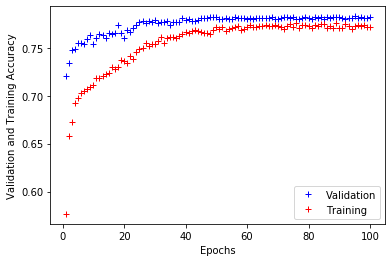

Maxima/minima of  accuracy/loss occurs at 0.782800018787384 / 0.6399454473495484 respectively and this occurs at epochs 95 / 95 respectively.


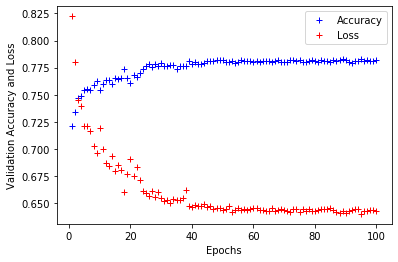

In [ ]:
model = Sequential()
model.add(UpSampling2D(input_shape=(32,32,3)))
model.add(base_model)
model.add(Flatten())
model.add(layers.BatchNormalization())
model.add(layers.Dense(128, activation='elu'))
model.add(layers.Dropout(0.4))
model.add(layers.BatchNormalization())
model.add(layers.Dense(64, activation='elu'))
model.add(layers.Dropout(0.4))
model.add(layers.BatchNormalization())
model.add(layers.Dense(no_classes, activation='softmax'))
model.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])



datagen = ImageDataGenerator(width_shift_range=0.1, height_shift_range=0.1, horizontal_flip=True)
it_train = datagen.flow(input_train, target_train, batch_size=64)
steps = int(input_train.shape[0] / 64)
fit = model.fit_generator(it_train, steps_per_epoch=steps, epochs=100, validation_data=(input_val,target_val), verbose=1)
plotgraphs(fit, 100)

In [ ]:
model.summary()
model.save('pretrained.h5')

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
up_sampling2d_2 (UpSampling2 (None, 64, 64, 3)         0         
_________________________________________________________________
vgg19 (Model)                multiple                  20024384  
_________________________________________________________________
flatten_2 (Flatten)          (None, 2048)              0         
_________________________________________________________________
batch_normalization_4 (Batch (None, 2048)              8192      
_________________________________________________________________
dense_4 (Dense)              (None, 128)               262272    
_________________________________________________________________
dropout_3 (Dropout)          (None, 128)               0         
_________________________________________________________________
batch_normalization_5 (Batch (None, 128)              

Fine Tuning is the process in which certain parts of the convolutional base used in transfer learning are made trainable again, in the hopes of increasing the specificity of the layers to the target dataset. This can not be done at the start as training a randomly initialised dense top and a large pretrained base will result in the magnitude of the gradient descent destroying some of the information learned in the convolutional base. 

In [ ]:
model = load_model("pretrained.h5")


base_model.trainable = True

set_trainable = False
for layer in base_model.layers:
    if layer.name == 'block5_conv1':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False
base_model.summary()

Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, None, None, 3)     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0     

C:\Users\charl\anaconda3\envs\env_ML\lib\site-packages\keras\engine\saving.py:384: UserWarning: Error in loading the saved optimizer state. As a result, your model is starting with a freshly initialized optimizer.
  warnings.warn('Error in loading the saved optimizer '


Epoch 1/8
625/625 [==============================] - 70s 112ms/step - loss: 0.5951 - accuracy: 0.7982 - val_loss: 0.4564 - val_accuracy: 0.8389
Epoch 2/8
625/625 [==============================] - 65s 105ms/step - loss: 0.4754 - accuracy: 0.8390 - val_loss: 0.4005 - val_accuracy: 0.8634
Epoch 3/8
625/625 [==============================] - 66s 106ms/step - loss: 0.4122 - accuracy: 0.8630 - val_loss: 0.3413 - val_accuracy: 0.8853
Epoch 4/8
625/625 [==============================] - 72s 116ms/step - loss: 0.3641 - accuracy: 0.8820 - val_loss: 0.3282 - val_accuracy: 0.8880
Epoch 5/8
625/625 [==============================] - 69s 110ms/step - loss: 0.3304 - accuracy: 0.8942 - val_loss: 0.3133 - val_accuracy: 0.8952
Epoch 6/8
625/625 [==============================] - 70s 112ms/step - loss: 0.2951 - accuracy: 0.9052 - val_loss: 0.2970 - val_accuracy: 0.9020
Epoch 7/8
625/625 [==============================] - 73s 117ms/step - loss: 0.2686 - accuracy: 0.9152 - val_loss: 0.2777 - val_accuracy:

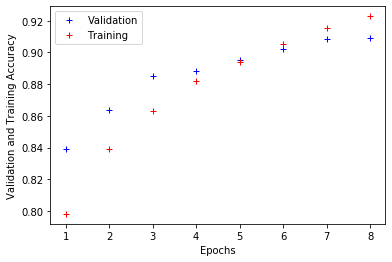

Maxima/minima of  accuracy/loss occurs at 0.9093000292778015 / 0.2739885640859604 respectively and this occurs at epochs 8 / 8 respectively.


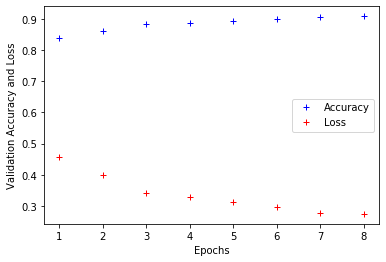

In [ ]:
from keras import optimizers

model.compile(loss='sparse_categorical_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-5),
              metrics=['accuracy'])

datagen = ImageDataGenerator(width_shift_range=0.1, height_shift_range=0.1, horizontal_flip=True)
it_train = datagen.flow(input_train, target_train, batch_size=64)
steps = int(input_train.shape[0] / 64)
fit = model.fit_generator(it_train, steps_per_epoch=steps, epochs=8, validation_data=(input_val,target_val), verbose=1)
plotgraphs(fit, 8)

In [ ]:
model.save('finetune.h5')

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
up_sampling2d_2 (UpSampling2 (None, 64, 64, 3)         0         
_________________________________________________________________
vgg19 (Model)                multiple                  20024384  
_________________________________________________________________
flatten_2 (Flatten)          (None, 2048)              0         
_________________________________________________________________
batch_normalization_4 (Batch (None, 2048)              8192      
_________________________________________________________________
dense_4 (Dense)              (None, 128)               262272    
_________________________________________________________________
dropout_3 (Dropout)          (None, 128)               0         
_________________________________________________________________
batch_normalization_5 (Batch (None, 128)              

In [ ]:
from keras import backend as K
model = load_model("dataug.h5")
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_13 (Conv2D)           (None, 32, 32, 32)        896       
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 32, 32, 32)        9248      
_________________________________________________________________
batch_normalization_7 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
dropout_9 (Dropout)          (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 16, 16, 64)        18496     
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 16, 16, 64)       

In [ ]:
from keras import backend as K
layer_name = 'conv2d_18'
filter_index = 0
layer_output = model.get_layer(layer_name).output
loss = K.mean(layer_output[:, :, :, filter_index])
grads = K.gradients(loss, model.input)[0]
grads /= (K.sqrt(K.mean(K.square(grads))) + 1e-5)
iterate = K.function([model.input], [loss, grads])
import numpy as np
loss_value, grads_value = iterate([np.zeros((1, 32, 32, 3))])
input_img_data = np.random.random((1, 32, 32, 3)) * 20 + 128.
step = 1.
for i in range(40):
    loss_value, grads_value = iterate([input_img_data])
    input_img_data += grads_value * step
def deprocess_image(x):
    x -= x.mean()
    x /= (x.std() + 1e-5)
    x *= 0.1

    # clip to [0, 1]
    x += 0.5
    x = np.clip(x, 0, 1)

    # convert to RGB array
    x *= 255
    x = np.clip(x, 0, 255).astype('uint8')
    return x

In [ ]:
def generate_pattern(layer_name, filter_index, size=32):
    layer_output = model.get_layer(layer_name).output
    loss = K.mean(layer_output[:, :, :, filter_index])
    grads = K.gradients(loss, model.input)[0]
    grads /= (K.sqrt(K.mean(K.square(grads))) + 1e-5)
    iterate = K.function([model.input], [loss, grads])
    input_img_data = np.random.random((1, size, size, 3)) * 20 + 128.


    step = 1.
    for i in range(40):
        loss_value, grads_value = iterate([input_img_data])
        input_img_data += grads_value * step
        
    img = input_img_data[0]
    return deprocess_image(img)

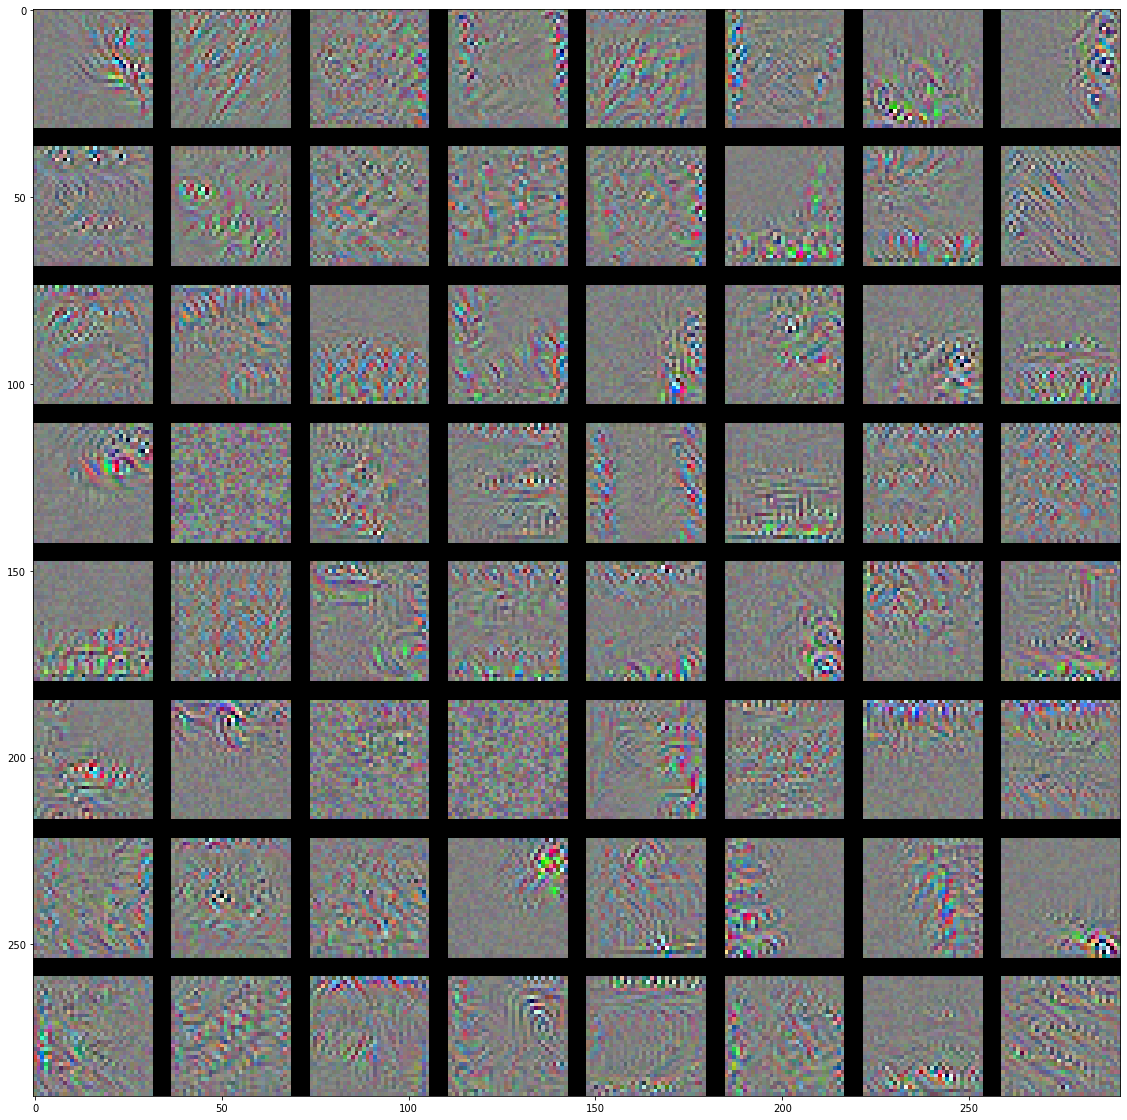

In [ ]:
for layer_name in ['conv2d_18']: 
    size = 32
    margin = 5


    results = np.zeros((8 * size + 7 * margin, 8 * size + 7 * margin, 3))

    for i in range(8): 
        for j in range(8):  
            filter_img = generate_pattern(layer_name, i + (j * 8), size=size)
            horizontal_start = i * size + i * margin
            horizontal_end = horizontal_start + size
            vertical_start = j * size + j * margin
            vertical_end = vertical_start + size
            results[horizontal_start: horizontal_end, vertical_start: vertical_end, :] = filter_img

    # Display the results grid
    plt.figure(figsize=(20, 20))
    plt.imshow(results.astype('uint8'))
    plt.show()

I can not make sense of this.

## Test it 

In [ ]:
model = load_model("finetune.h5")
score = model.evaluate(input_test, target_test, verbose=0)
print('Test loss: {}'.format(score[0]))
print('Test accuracy: {}'.format(score[1]))
model.summary()

Test loss: 0.2852197519958019
Test accuracy: 0.901199996471405
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
up_sampling2d_2 (UpSampling2 (None, 64, 64, 3)         0         
_________________________________________________________________
vgg19 (Model)                multiple                  20024384  
_________________________________________________________________
flatten_2 (Flatten)          (None, 2048)              0         
_________________________________________________________________
batch_normalization_4 (Batch (None, 2048)              8192      
_________________________________________________________________
dense_4 (Dense)              (None, 128)               262272    
_________________________________________________________________
dropout_3 (Dropout)          (None, 128)               0         
_________________________________________________________

In [ ]:
model = load_model("dataug.h5")
score = model.evaluate(input_test, target_test, verbose=0)
print('Test loss: {}'.format(score[0]))
print('Test accuracy: {}'.format(score[1]))
model.summary()

Test loss: 0.43457225346565245
Test accuracy: 0.904500009059906
Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_13 (Conv2D)           (None, 32, 32, 32)        896       
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 32, 32, 32)        9248      
_________________________________________________________________
batch_normalization_7 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
dropout_9 (Dropout)          (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 16, 16, 64)        18496     
________________________________________________________

## In depth analysis

In [ ]:
pred = model.predict(input_test)
prediction = np.round(model.predict(input_test))
prediction = prediction.argmax(axis=-1)

In [ ]:
testing = target_test.astype(int)

In [ ]:
new = list(range(0,len(target_test)))
for i in list(range(0,len(target_test))):
    new[i] = prediction[i]!=testing[i][0]

In [ ]:
np.where(new)

(array([  24,   35,   37, ..., 9982, 9985, 9989], dtype=int64),)

In [ ]:
pred[35]

array([1.3826582e-04, 9.6570225e-03, 7.1904967e-03, 2.4105787e-01,
       9.1345917e-04, 1.4096109e-02, 3.9786842e-02, 1.9422757e-03,
       6.8310070e-01, 2.1169072e-03], dtype=float32)

In [ ]:
target_test[35][0]

2

In [ ]:
(i, t), (visualisation, t) = cifar10.load_data()

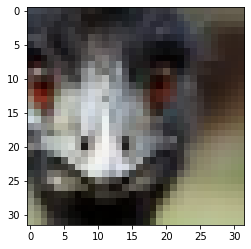

In [ ]:
from matplotlib import pyplot
pyplot.imshow(visualisation[35], cmap=pyplot.get_cmap('gray')) 

The model has predicted this image to be a ship (Category 9 (8+1)). The true category for this is bird. A possible reason for it struggling may be the darker colours and pointy edges all similar to ships. The model has not done terribly, as its second prediction is bird.

In [ ]:
pred[9982]

array([2.5348356e-06, 1.1900738e-05, 3.8168316e-03, 1.0755011e-03,
       1.0108626e-03, 2.4787273e-04, 9.9381363e-01, 5.4305697e-06,
       7.3031224e-06, 8.0556601e-06], dtype=float32)

In [ ]:
target_test[9982][0]

2

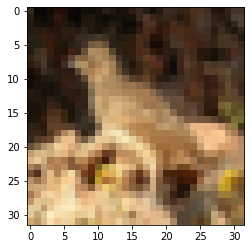

In [ ]:
pyplot.imshow(visualisation[9982], cmap=pyplot.get_cmap('gray')) 

Again, the model seems to struggle with the bird category. This time it has predicted it to be a frog.